In [1]:
### SKRIPT BY THOMAS BRIAN WINKLER
### PART OF THE ARTICLE "ENEGETICS AND DYNAMICS OF A STABLE BLOCH POINT" by Winkler et al. (2023)
from magnum import *
from math import *
import numpy as np
import random
import os.path
import os
import time
import sys
import re
import matplotlib.pyplot as plt
%matplotlib inline

[   INFO] - Imported FFTW wisdom from file
[   INFO] - ----------------------------------------------------------------------
[   INFO] - MicMag 2.0rc0
[   INFO] - Copyright (C) 2012 - 2023 by the MicroMagnum team and the MicMag2 contributors.
[   INFO] - This program comes with ABSOLUTELY NO WARRANTY.
[   INFO] - This is free software, and you are welcome to redistribute it under
[   INFO] - certain conditions; see the file COPYING in the distribution package.
[   INFO] - ----------------------------------------------------------------------
[  DEBUG] - GPU is disabled!
[   INFO] - FFTW using 1 threads from now on


In [2]:
def calcBPMM(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))

    solver = create_solver(world, module_list =[StrayField, ExchangeField,  DMIField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
   
    folder = system+"/MM_"+sample+"/"
    

    if not os.path.isdir(folder): os.mkdir(folder)
    

    
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor    
    
    
    filename_load = system+"_relaxed_nt_"+str(nt)+".omf"
    solver.state.M = readOMF("BP/MM_"+sample+"/"+filename_load)
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    solver.state.M.normalize(Ms)
    return (solver.state.E_tot, solver.state.E_exch, solver.state.E_dmi, solver.state.E_stray)

def calcBVMM(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))

    solver = create_solver(world, module_list =[StrayField, ExchangeField,  DMIField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
   
    folder = system+"/MM_"+sample+"/"
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor    
    
    filename_load = system+"_relaxed_nt_"+str(nt)+".omf"
    solver.state.M = readOMF(system+"/MM_"+sample+"/"+filename_load)
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()

    solver.state.M.normalize(Ms)
    return (solver.state.E_tot, solver.state.E_exch, solver.state.E_dmi, solver.state.E_stray)
def calcFMMM(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))

    solver = create_solver(world, module_list =[StrayField, ExchangeField,  DMIField],
                           finescale = False,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
   
    folder = system+"/MM_"+sample+"/"
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor    
    
    filename_load = system+"_FMinit_nt_"+str(nt)+".omf"
    solver.state.M = (0,0,1) #readOMF(system+"/MM_"+sample+"/"+filename_load)
    #solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()

    solver.state.M.normalize(Ms)
    return (solver.state.E_tot, solver.state.E_exch, solver.state.E_dmi, solver.state.E_stray)

def calcBPHB(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))

    solver = create_solver(world, module_list =[FSStrayField, FSExchangeField,  FSDMIField],
                           finescale = True,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
 
    folder = system+"/HB_"+sample+"/"
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor    
    
    
    filename_load = system+"_relaxed_nt_"+str(nt)+".omf"
    solver.state.M = readOMF(system+"/HB_"+sample+"/"+filename_load)
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()

    solver.state.M.normalize(mu)
    solver.state.mu = mu
    solver.state.Ms = Ms 
    return (solver.state.E_tot, solver.state.E_exch, solver.state.E_dmi, solver.state.E_stray)

def calcBVHB(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))
    solver = create_solver(world, module_list =[FSStrayField, FSExchangeField,  FSDMIField],
                           finescale = True,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
 
    folder = system+"/HB_"+sample+"/"
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor    
    
    filename_load = system+"_relaxed_nt_"+str(nt)+".omf"
    solver.state.M = readOMF(system+"/HB_"+sample+"/"+filename_load)
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()

    solver.state.M.normalize(mu)
    solver.state.mu = mu
    solver.state.Ms = Ms
    return (solver.state.E_tot, solver.state.E_exch, solver.state.E_dmi, solver.state.E_stray)

def calcFMHB(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))
    solver = create_solver(world, module_list =[FSStrayField, FSExchangeField,  FSDMIField],
                           finescale = True,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
 
    folder = system+"/HB_"+sample+"/"
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor    
    
    filename_load = system+"_FMinit_nt_"+str(nt)+".omf"
    solver.state.M = (0,0,mu) #readOMF(system+"/HB_"+sample+"/"+filename_load)
    solver.state.M.normalize(1)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization")
    plt.show()
    solver.state.M.normalize(mu)
    solver.state.mu = mu
    solver.state.Ms = Ms  
    return (solver.state.E_tot, solver.state.E_exch, solver.state.E_dmi, solver.state.E_stray)

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=79.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG] - Re

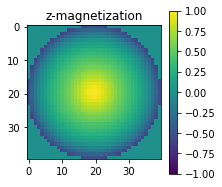

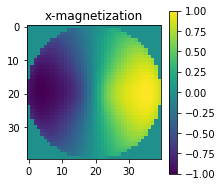

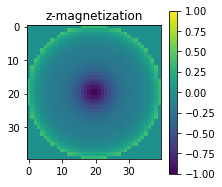

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 80x80x20 cells
[   INFO] -   FFT size        : 160x160x40
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--80-80-20--160-160-40--1169-1169-1169.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG] 

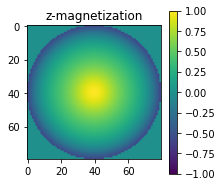

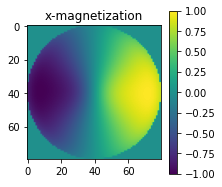

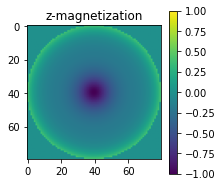

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 120x120x30 cells
[   INFO] -   FFT size        : 240x240x60
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--120-120-30--240-240-60--779-779-779.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG]

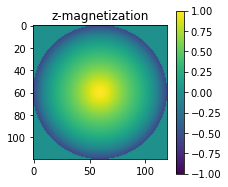

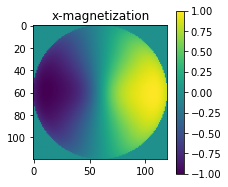

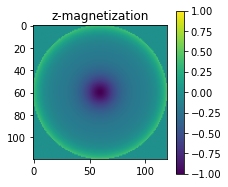

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 160x160x40 cells
[   INFO] -   FFT size        : 320x320x80
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--160-160-40--320-320-80--584-584-584.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG]

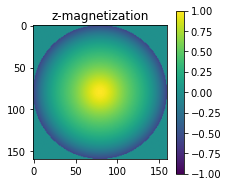

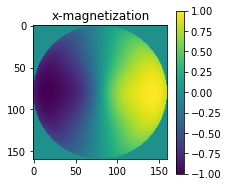

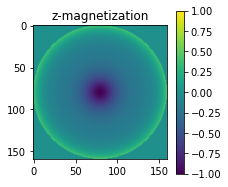

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.6%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBU

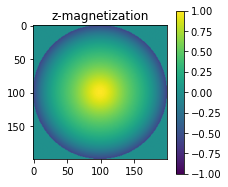

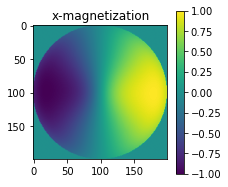

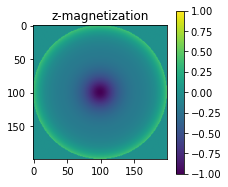

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=79.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG] - Re

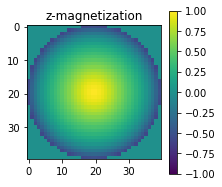

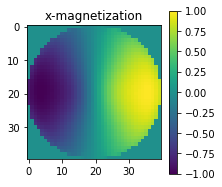

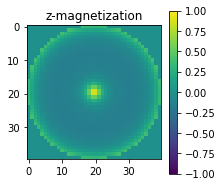

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 80x80x20 cells
[   INFO] -   FFT size        : 160x160x40
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--80-80-20--160-160-40--1169-1169-1169.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG] 

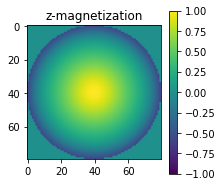

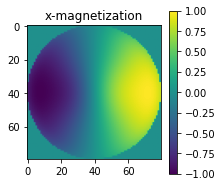

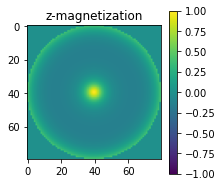

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 120x120x30 cells
[   INFO] -   FFT size        : 240x240x60
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--120-120-30--240-240-60--779-779-779.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG]

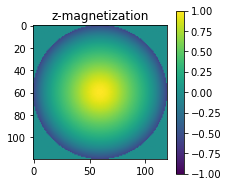

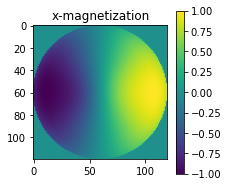

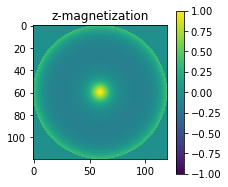

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 160x160x40 cells
[   INFO] -   FFT size        : 320x320x80
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--160-160-40--320-320-80--584-584-584.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBUG]

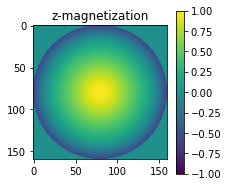

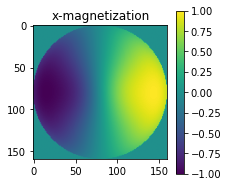

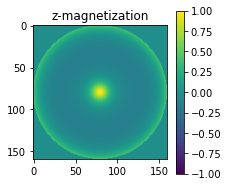

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.6%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).
[  DEBU

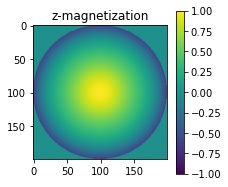

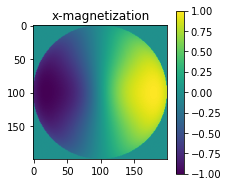

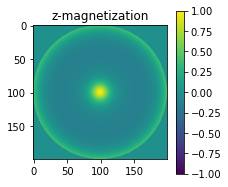

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 40x40x10 cells
[   INFO] -   FFT size        : 80x80x20
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--40-40-10--80-80-20--2339-2339-2339.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=79.0%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).


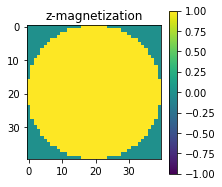

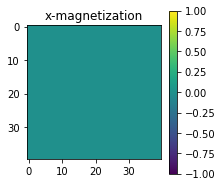

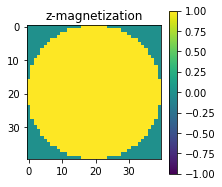

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 80x80x20 cells
[   INFO] -   FFT size        : 160x160x40
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--80-80-20--160-160-40--1169-1169-1169.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).


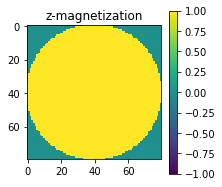

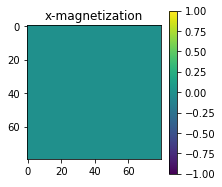

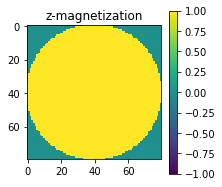

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 120x120x30 cells
[   INFO] -   FFT size        : 240x240x60
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--120-120-30--240-240-60--779-779-779.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).


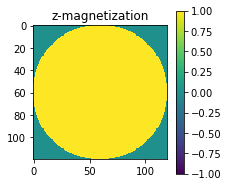

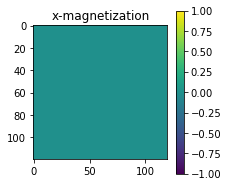

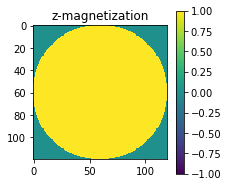

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 160x160x40 cells
[   INFO] -   FFT size        : 320x320x80
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--160-160-40--320-320-80--584-584-584.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.5%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).


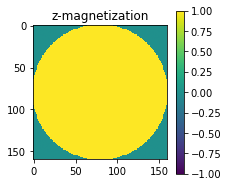

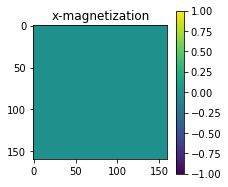

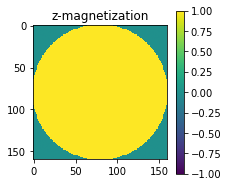

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, StrayField, ExchangeField, DMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.6%, params: 'Ms=384000', 'alpha=0.28', 'A=8.78e-12'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps_abs=0.001, eps_rel=0.0001).


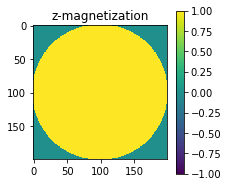

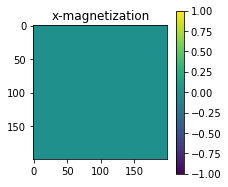

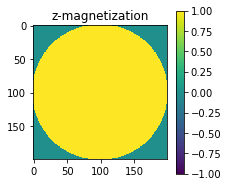

In [4]:
a=0.4679*1e-09   # lattice constant of FeGe in m
ntlist = [10, 20, 30,40, 50]
dlist = [200*a/(4*n) for n in ntlist]

sample ="cylindrical" #in study: rectangular
system= "BP" #chossing configurations Bloch point (BP)

if os.path.isfile(system):
    os.mkdir(system)
e_tots_bpmm = []
e_exchs_bpmm = []
e_dmis_bpmm = []
e_strays_bpmm = []

for nt in ntlist: # thickness in units of FeGe lattice constant, in study [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90]. 50 equals the atomistic lattice constant.
    (e_tot_bpmm, e_exch_bpmm, e_dmi_bpmm, e_stray_bpmm) = calcBPMM(nt, system, sample)
    e_tots_bpmm.append(e_tot_bpmm)
    e_exchs_bpmm.append(e_exch_bpmm)
    e_dmis_bpmm.append(e_dmi_bpmm)
    e_strays_bpmm.append(e_stray_bpmm)

system= "BV" #chossing configurations Bloch point (BP)
if os.path.isfile(system):
    os.mkdir(system)
e_tots_bvmm = []
e_exchs_bvmm = []
e_dmis_bvmm = []
e_strays_bvmm = []

for nt in ntlist: # thickness in units of FeGe lattice constant, in study [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90]. 50 equals the atomistic lattice constant.
    (e_tot_bvmm,e_exch_bvmm,e_dmi_bvmm,e_stray_bvmm) = calcBVMM(nt, system, sample)
    e_tots_bvmm.append(e_tot_bvmm)
    e_exchs_bvmm.append(e_exch_bvmm)
    e_dmis_bvmm.append(e_dmi_bvmm)
    e_strays_bvmm.append(e_stray_bvmm)

e_tots_fmmm = []
e_exchs_fmmm = []
e_dmis_fmmm = []
e_strays_fmmm = []

for nt in ntlist: # thickness in units of FeGe lattice constant, in study [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90]. 50 equals the atomistic lattice constant.
    (e_tot_fmmm, e_exch_fmmm, e_dmi_fmmm, e_stray_fmmm) = calcFMMM(nt, system, sample)
    e_tots_fmmm.append(e_tot_fmmm)
    e_exchs_fmmm.append(e_exch_fmmm)
    e_dmis_fmmm.append(e_dmi_fmmm)
    e_strays_fmmm.append(e_stray_fmmm)

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, FSStrayField, FSExchangeField, FSDMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.6%, params: 'mu=3.9336e-23', 'alpha=0.28', 'J=8.21632e-21'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps=0.001, eps_rel=0.0001)

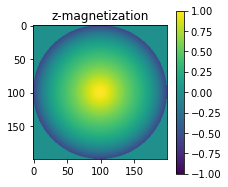

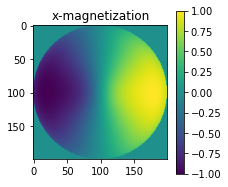

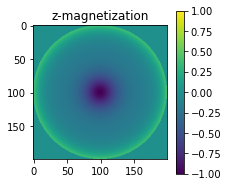

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, FSStrayField, FSExchangeField, FSDMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.6%, params: 'mu=3.9336e-23', 'alpha=0.28', 'J=8.21632e-21'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps=0.001, eps_rel=0.0001)

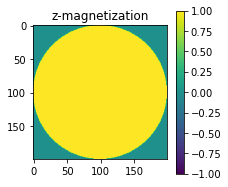

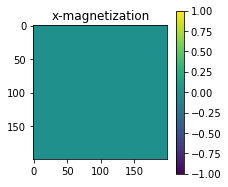

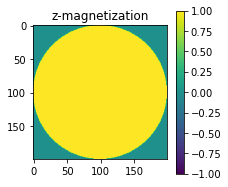

[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[  DEBUG] - calculateDemagTensor: calculating with 64 bit working precision.
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[  DEBUG] - Using CPU routines for Matrix-Vector convolution
[  DEBUG] - Convolution is 3D
[   INFO] - Initialized modules: LandauLifshitzGilbert, FSStrayField, FSExchangeField, FSDMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=78.6%, params: 'mu=3.9336e-23', 'alpha=0.28', 'J=8.21632e-21'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps=0.001, eps_rel=0.0001)

In [ ]:
a=0.4679*1e-09   # lattice constant of FeGe in m
n_hb = 50 #
d_hb = a

sample ="cylindrical" #in study used rectangular
system= "BP" #chossing configurations Bloch point (BP)

(e_tot_bphb, e_exch_bphb, e_dmi_bphb, e_stray_bphb) = calcBPHB(n_hb, system, sample)
(e_tot_fmhb, e_exch_fmhb, e_dmi_fmhb, e_stray_fmhb) = calcFMHB(n_hb, system, sample)

system= "BV" #chossing configurations bilayer vortex (bilayer vortex)
(e_tot_bvhb,e_exch_bvhb,e_dmi_bvhb,e_stray_bvhb) = calcBVHB(nt, system, sample)
#(e_tot_fmhb, e_exch_fmhb, e_dmi_fmhb, e_stray_fmhb) = calcBVHB(n_hb, system, sample)

In [ ]:
ms = 0.384e6
a=0.4679e-9
mu = ms*a**3
plt.figure(figsize=(4,4))
plt.title("E_tot")
#numberofcells = 200*200*50
plt.plot(dlist, np.array(e_tots_bpmm)-np.array(e_tots_fmmm), "o-", label="BP MM")
plt.plot(dlist, np.array(e_tots_bvmm)-np.array(e_tots_fmmm), "o-", label="BV MM")
plt.plot(d_hb, e_tot_bphb-e_tot_fmhb, "o", label="BP HB")
plt.plot(d_hb, e_tot_bvhb-e_tot_fmhb, "o", label="BV HB")
plt.grid()
plt.legend()
plt.savefig("../Figures/Fig_2a_e_tot.svg", dpi=400, bbox_inches="tight")
plt.plot()

plt.figure(figsize=(4,4))
plt.title("E_exch")
plt.plot(dlist, np.array(e_exchs_bpmm)-np.array(e_exchs_fmmm), "o-", label="BP MM")
plt.plot(dlist, np.array(e_exchs_bvmm)-np.array(e_exchs_fmmm), "o-", label="BV MM")
plt.plot(d_hb, e_exch_bphb-e_exch_fmhb, "o", label="BP")
plt.plot(d_hb, e_exch_bvhb-e_exch_fmhb, "o", label="BV")
plt.grid()
plt.legend()
plt.savefig("../Figures/Fig_2b_e_exch.svg", dpi=400, bbox_inches="tight")
plt.plot()

plt.figure(figsize=(4,4))
plt.title("E_dmi")
plt.plot(dlist, e_dmis_bpmm, "o-", label="BP MM")
plt.plot(dlist, e_dmis_bvmm, "o-", label="BV MM")
plt.plot(d_hb, e_dmi_bphb-e_dmi_fmhb, "o", label="BP")
plt.plot(d_hb, e_dmi_bvhb-e_dmi_fmhb, "o-", label="BV")
plt.grid()
plt.legend()
plt.savefig("../Figures/Fig_2c_e_dmi.svg", dpi=400, bbox_inches="tight")
plt.plot()

plt.figure(figsize=(4,4))
plt.title("E_stray")
plt.plot(d_hb, e_stray_bphb-e_stray_fmhb,"o-", label="BP")
plt.plot(d_hb, e_stray_bvhb-e_stray_fmhb,"o-", label="BV")
plt.plot(dlist, np.array(e_strays_bpmm)-np.array(e_strays_fmmm), "o-", label="BP MM")
plt.plot(dlist, np.array(e_strays_bvmm)-np.array(e_strays_fmmm), "o-", label="BV MM")
plt.grid()
plt.legend()
plt.savefig("../Figures/Fig_2d_e_demag.svg", dpi=400, bbox_inches="tight")
plt.plot()